In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from utils.information_processing_capacity import single_input_ipc

gpu_id = 0
cp.cuda.Device(gpu_id).use()

In this demostraion, we use one-dimensional echo state network (ESN). 

In [3]:
#Parameters for one-dimensional esn
Two = 10000
T = int(1e6)
rho = 0.9
iota = 0.3

degdelays = [[1,50],[2,30],[3,15],[4,8],[5,8],[6,8],[7,8],[8,8]]

##### Generalized polynomial chaos

The type of polynomial is automatically determined by the type of input distribution. 
We can use not only Legendre polynoial with uniformed random input but also seven other sets of polynomial and input---i.e., Hermite with Gaussian, Jacobi with beta, Laguerre with gamma, Charlier with Poisson, Krawtchouk with binomial, Meixner with negative binomial, and Hahn with hyper geometric. 
Please see [2] for further details. 

In the following code, we demostrate how to use the eight polynomials including Legendre. 
To compute IPCs, we need to specify the input sequence `zeta`, the polynomial type `poly`, the type of input distribution `distr`, as arguments of class `single_input_ipc`. 
Note that, in some cases, we need to additionally specify parameters for input and polynomial as an argument `poly_params`. 

In [5]:
np.random.seed(0)
# Hermite and Legendre polynoials
zeta = {'hermite':np.random.randn(Two+T),'legendre':2*np.random.rand(Two+T)-1}
params = {'hermite':{},'legendre':{}}
# Jacobi 
a,b = 3/4,3/4
alpha,beta = a-1,b-1
params['jacobi'] = {'alpha':alpha,'beta':beta}
zeta['jacobi'] = 2*np.random.beta(a,b,Two+T)-1
# Laguerre
a = 1
params['laguerre'] = {'a':a}
zeta['laguerre'] = np.random.gamma(a+1,1,Two+T)
# Charlier
a = 6
params['charlier'] = {'a':a}
zeta['charlier'] = np.random.poisson(a,Two+T)
# Krawtchouk
N,p = 10,0.5
params['krawtchouk'] = {'N':N,'p':p}
zeta['krawtchouk'] = np.random.binomial(N,p,Two+T)
# Meixner
c,beta = 0.2,10
params['meixner'] = {'c':c,'beta':beta}
zeta['meixner'] = np.random.negative_binomial(beta,1-c,Two+T)
# Hahn
m,n,l = 100,50,20
params['hahn'] = {'alpha':-m-1,'beta':-n-1,'N':l}
zeta['hahn'] = np.random.hypergeometric(m,n,l,Two+T)

polys = ['hermite','legendre','jacobi','laguerre','charlier','krawtchouk','meixner','hahn']
distr = {'hermite':'gauss','laguerre':'gamma','jacobi':'beta','legendre':'uniform',
		 'charlier':'poisson','krawtchouk':'binomial','meixner':'negative_binomial','hahn':'hypergeometric'}
for poly in polys:
	ipc = single_input_ipc(zeta[poly],Two,degdelays,distr=distr[poly],poly=poly,poly_params=params[poly],zerobased=False)

	print(poly,'spectral radius',rho,'input intensity',iota)

	#state
	x = 0.*np.ones(Two+T)
	for t in range(1,Two+T):
		x[t] = np.tanh(rho*x[t-1]+iota*zeta[poly][t-1])

	ipc.svd(x)
	path = 'ipc/pkl/%s_%.2f_%.2f'%(poly,rho,iota)
	ipc.save_config(path)

	# IPC
	Ctot = 0
	for deg,delay in degdelays:
		ipcs,surs = ipc.compute(deg,delay)
		truncated = ipc.threshold(ipcs,surs,deg,delay,th_scale=1.2,display=False)
		Ctot_deg = np.sum(truncated['ipcs'].values)
		print('deg',deg,'delay',delay,'Ctot(d)',Ctot_deg)
		Ctot += Ctot_deg
	print('degs',ipc.degs,'Ctot',Ctot,'rank',ipc.rank)
	print('--------------------------------------------------------------------------------\n\n\n')
	


hermite spectral radius 0.9 input intensity 0.3
{'N': 1, 'T': 1000000, 'Two': 10000, 'Nseed': 200, 'degdelays': [[1, 50], [2, 30], [3, 15], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8]], 'zerobased': False, 'poly': 'hermite', 'distr': 'gauss', 'thresh': 'N', 'finfo': 2.220446049250313e-16, 'rank': 1}
deg 1 delay 50 Ctot(d) 0.96286358170521
deg 2 delay 30 Ctot(d) 0.0
deg 3 delay 15 Ctot(d) 0.029320045978614102
deg 4 delay 8 Ctot(d) 5.1015485275458135e-05
deg 5 delay 8 Ctot(d) 0.002163577586387473
deg 6 delay 8 Ctot(d) 0.0005135285799439494
deg 7 delay 8 Ctot(d) 0.000804024160632068
deg 8 delay 8 Ctot(d) 0.000825609696929142
degs [1 2 3 4 5 6 7 8] Ctot 0.9965413831929922 rank 1
--------------------------------------------------------------------------------



legendre spectral radius 0.9 input intensity 0.3
{'N': 1, 'T': 1000000, 'Two': 10000, 'Nseed': 200, 'degdelays': [[1, 50], [2, 30], [3, 15], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8]], 'zerobased': False, 'poly': 'legendre', 'distr': 'unifo

##### Arbitrary polynomials chaos
If we use input distribution other than the eight ones, arbitrary polynomials chaos (aPC) is available. 
aPC prepares orthogonal polynomials using the Gram-Schmidt procedure. So we can use arbitrary random input. 

To use aPC, we need to specify `poly='gramschmidt'` as the argument of `single_input_ipc()` 
and can use any name for the argument `distr` such as `unknown`. 
In the following code, we demostrate computation of IPCs with mixed Gaussian input distribution. 

gramschmidt unknown spectral radius 0.9 input intensity 0.3
{'N': 1, 'T': 1000000, 'Two': 10000, 'Nseed': 200, 'degdelays': [[1, 50], [2, 30], [3, 15], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8]], 'zerobased': False, 'poly': 'gramschmidt', 'distr': 'unknown', 'thresh': 'N', 'finfo': 2.220446049250313e-16, 'rank': 1}
deg 1 delay 50 Ctot(d) 0.9806024247370668
deg 2 delay 30 Ctot(d) 2.3395480689864132e-05
deg 3 delay 15 Ctot(d) 0.014211521805298454
deg 4 delay 8 Ctot(d) 9.522769240845023e-06
deg 5 delay 8 Ctot(d) 0.00018576091447705114
deg 6 delay 8 Ctot(d) 5.3018706626692584e-05
deg 7 delay 8 Ctot(d) 0.00029836643351394387
deg 8 delay 8 Ctot(d) 0.0008598615833945276
degs [1 2 3 4 5 6 7 8] Ctot 0.9962438724303083 rank 1
--------------------------------------------------------------------------------



gramschmidt mixed_gauss spectral radius 0.9 input intensity 0.3
{'N': 1, 'T': 1000000, 'Two': 10000, 'Nseed': 200, 'degdelays': [[1, 50], [2, 30], [3, 15], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8

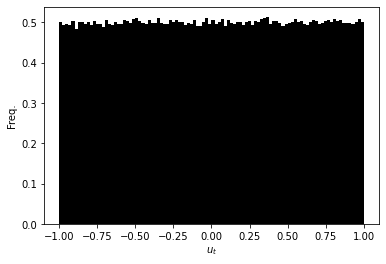

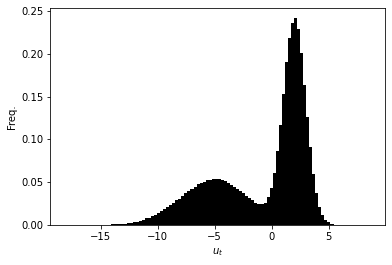

In [6]:

poly = 'gramschmidt'
distrs = ['unknown','mixed_gauss']

zeta = dict()
zeta['unknown'] = 2*np.random.rand(Two+T)-1

p = np.random.randint(0,100,Two+T) < 40
zeta['mixed_gauss'] = p*np.random.normal(loc=-5,scale=3,size=Two+T) \
					+ (1-p)*np.random.normal(loc=2,scale=1,size=Two+T)

for distr in distrs:
	print(poly,distr,'spectral radius',rho,'input intensity',iota)
	
	plt.figure()
	plt.hist(zeta[distr],density=True,color='k',bins=100)
	plt.xlabel(r'$u_t$')
	plt.ylabel('Freq.')

	ipc = single_input_ipc(zeta[distr],Two,degdelays,distr=distr,poly=poly,zerobased=False)

	#state
	x = 0.*np.ones(Two+T)
	for t in range(1,Two+T):
		x[t] = np.tanh(rho*x[t-1]+iota*zeta[distr][t-1])

	ipc.svd(x)
	path = 'ipc/pkl/%s_%s_%.2f_%.2f'%(poly,distr,rho,iota)
	ipc.save_config(path)

	Ctot = 0
	for deg,delay in degdelays:
		ipcs,surs = ipc.compute(deg,delay)
		truncated = ipc.threshold(ipcs,surs,deg,delay,th_scale=1.2,display=False)
		Ctot_deg = np.sum(truncated['ipcs'].values)
		print('deg',deg,'delay',delay,'Ctot(d)',Ctot_deg)
		Ctot += Ctot_deg
	print('degs',ipc.degs,'Ctot',Ctot,'rank',ipc.rank)
	print('--------------------------------------------------------------------------------\n\n\n')
